In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
X = np.load('data/X.npy') # image
Y = np.load('data/Y.npy') # label (0 = Not IDC, 1 = IDC)

In [4]:
# Data Sharding
X_train, X_test, Y_train, Y_test = train_test_split(X/225.0, Y, test_size=0.2, stratify=Y)
X_train.shape, Y_train.shape

((4437, 50, 50, 3), (4437,))

In [5]:
Y_train = to_categorical(Y_train, num_classes = 2) 
Y_test = to_categorical(Y_test, num_classes = 2)

In [6]:
# callback function
class MetricsCheckpoint(Callback):
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)
        
# learning curve
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy', allow_pickle=True)[()] # 加载 logs.npy
    filt = ['acc'] 
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', 
                 label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l) 
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, 
                    c='r' if 'val' not in k else 'b') 
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', 
                 color= 'r' if 'val' not in k else 'b')  
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    
def plot_confusion_matrix(cm, classes,normalize=False,
                          title='Confusion matrix',cmap=plt.cm.Blues):

    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)                                    # title
    plt.colorbar()                                      # color bar
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=90)        # x axis
    plt.yticks(tick_marks, classes)                     # y axis
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label') 
    plt.xlabel('Predicted label')

model saved
Epoch 1/50
138/138 [==============================] - 1s 5ms/step - loss: 0.7002 - accuracy: 0.5490 - val_loss: 0.6312 - val_accuracy: 0.6685 - lr: 0.0010
Epoch 2/50
138/138 [==============================] - 1s 4ms/step - loss: 0.6314 - accuracy: 0.6516 - val_loss: 0.5967 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 3/50
138/138 [==============================] - 1s 4ms/step - loss: 0.5707 - accuracy: 0.7293 - val_loss: 0.5409 - val_accuracy: 0.7450 - lr: 0.0010
Epoch 4/50
138/138 [==============================] - 1s 4ms/step - loss: 0.5539 - accuracy: 0.7336 - val_loss: 0.5516 - val_accuracy: 0.7144 - lr: 0.0010
Epoch 5/50
138/138 [==============================] - 1s 4ms/step - loss: 0.5343 - accuracy: 0.7501 - val_loss: 0.5380 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 6/50
138/138 [==============================] - 1s 4ms/step - loss: 0.5263 - accuracy: 0.7507 - val_loss: 0.5192 - val_accuracy: 0.7586 - lr: 0.0010
Epoch 7/50
138/138 [==============================] - 1s 4

Epoch 47/50
138/138 [==============================] - 1s 4ms/step - loss: 0.1628 - accuracy: 0.9419 - val_loss: 0.8363 - val_accuracy: 0.7568 - lr: 3.1250e-05
Epoch 48/50
138/138 [==============================] - 1s 5ms/step - loss: 0.1625 - accuracy: 0.9396 - val_loss: 0.8430 - val_accuracy: 0.7559 - lr: 3.1250e-05
Epoch 49/50
138/138 [==============================] - 1s 4ms/step - loss: 0.1566 - accuracy: 0.9428 - val_loss: 0.8456 - val_accuracy: 0.7559 - lr: 3.1250e-05
Epoch 50/50
138/138 [==============================] - 1s 4ms/step - loss: 0.1576 - accuracy: 0.9387 - val_loss: 0.8296 - val_accuracy: 0.7568 - lr: 3.1250e-05

Keras CNN #1C - accuracy: 0.7567567825317383 


              precision    recall  f1-score   support

      IDC(-)       0.77      0.74      0.75       552
      IDC(+)       0.75      0.78      0.76       558

    accuracy                           0.76      1110
   macro avg       0.76      0.76      0.76      1110
weighted avg       0.76      0.76      

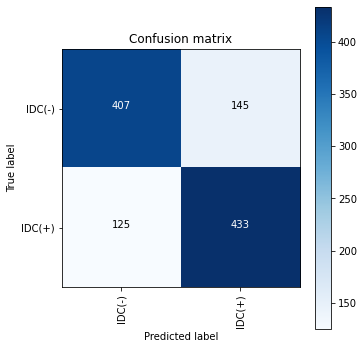

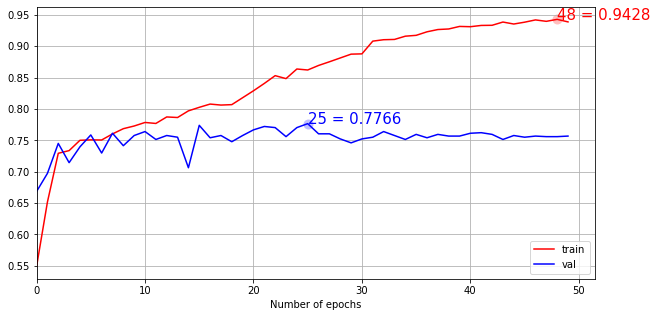

In [11]:
def runKerasCNNAugment(x_train,y_train,x_test, y_test):

    batch_size = 128 # size of each input
    num_classes = 2  # IDC=0,IDC=1
    epochs = 50
    input_shape = X_train.shape[1:] # Input size
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    #model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu')) 
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='sigmoid'))
    #model.summary()    
    
    model.save('./model/model-6.h5')
    print('model saved')    

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    
    Reduce=ReduceLROnPlateau(monitor='val_accuracy', factor=0.5,
                         patience=5,verbose=1,mode='auto',
                         epsilon=0.0001,cooldown=0,min_lr=0)

    model.fit(x_train,y_train,batch_size=32,
                        steps_per_epoch=len(x_train) / 32, 
                        epochs=epochs, 
                        validation_data = (x_test, y_test),
                        callbacks = [MetricsCheckpoint('logs'),Reduce])
    
    score = model.evaluate(x_test, y_test, verbose=0) 
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    
    y_pred = model.predict(x_test) 
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    
    # Generate text report
    print('\n', classification_report(np.where(y_test > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    
    # model evaluation
    score = model.evaluate(x_test, y_test, verbose=0) 
    Y_pred_classes = np.argmax(y_pred,axis = 1)
    Y_true = np.argmax(Y_test,axis = 1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
    plot_confusion_matrix(confusion_mtx, classes = list(map_characters.values())) 
    
runKerasCNNAugment(X_train, Y_train,  X_test, Y_test) 
plotKerasLearningCurve()